###  Load and check dimensions

In [1]:
import pandas as pd
import numpy as np

#load data
df = pd.read_csv("electrical_grid_data.csv")

#print dimensions
print("Data dimensions:",df.shape)

print(df.info())
print(df.head())

print("Null value check:",df.isnull().sum())

Data dimensions: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB
None
       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -

### Classify using SVM with three different kernels.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,classification_report,roc_auc_score
from sklearn.preprocessing import LabelEncoder,StandardScaler

df_org = df.copy()
# Encode target variable
le = LabelEncoder()
### df['stabf'] = df['stabf'].map({'unstable':0,'stable':1})
df['stabf'] = le.fit_transform(df['stabf'])

# Features and Target
X = df.drop(columns=['stab','stabf'])
y = df['stabf']

# Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train Test split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y, test_size=0.2,stratify=y,random_state=7)

# Kernels to test
kernels = ['linear','poly','rbf']
result = []

for k in kernels:
    if k == 'poly':
        model = SVC(kernel = k, C=1, degree=3, gamma='scale', random_state=7)
    else:
        model = SVC(kernel = k, C=1, gamma='scale', random_state=7)

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test))
    #classification_report = classification_report(y_test,y_pred)

    result.append((k,accuracy,precision,recall,f1,roc_auc))

# result to dataframe
result_df = pd.DataFrame(result,columns=['Kernel','Accuracy','Precision','Recall','F1 Score','Roc Auc'])
print(result_df)
    
    

   Kernel  Accuracy  Precision    Recall  F1 Score   Roc Auc
0  linear    0.8110   0.833086  0.880094  0.855945  0.888940
1    poly    0.8775   0.863797  0.959248  0.909023  0.909956
2     rbf    0.9510   0.954475  0.969436  0.961897  0.992297


Three Support Vector Machine (SVM) models:

        Linear
        Polynomial (degree = 3)
        Radial Basis Function (RBF)

Results:

    Kernel           Accuracy  Precision    Recall  F1-Score  ROC–AUC
    Linear	         0.8110    0.8331	0.8801   0.8559	  0.8889
    Polynomial	 0.8775	   0.8638       0.9592   0.9090	  0.9100
    RBF	         0.9510	   0.9545       0.9694   0.9619	  0.9923

Hyperparameters:

        Linear: C=1
        Polynomial: C=1, degree=3, gamma='scale'
        RBF: C=1, gamma='scale'      
        All models: random_state=7

The RBF kernel achieved the best performance, with 95% accuracy and a ROC–AUC of 0.9923, indicating strong separability between stable and unstable states. The polynomial kernel outperformed the linear kernel, suggesting that the dataset contains non-linear decision boundaries. While the linear kernel achieved the lowest accuracy (81.10%), it remains a viable choice when prioritizing model simplicity and computational efficiency.

Overall, the RBF kernel is recommended for this dataset when the goal is maximum predictive performance.


###  Try different C values for each kernel function.

In [3]:
### Since I need to call with different C , I build a function

def evaluate_svm_kernels(X_train, X_test, y_train, y_test, kernels, C_values):
   
    results = []
    for kernel in kernels:
        for C in C_values:
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, degree=3, gamma='scale', random_state=7)
            else:
                model = SVC(kernel=kernel, C=C, gamma='scale', random_state=7)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_score = model.decision_function(X_test)  # for ROC–AUC
            
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_score)
            
            results.append({
                'Kernel': kernel,
                'C': C,
                'Accuracy': round(acc, 4),
                'Precision': round(prec, 4),
                'Recall': round(rec, 4),
                'F1-Score': round(f1, 4),
                'ROC-AUC': round(auc, 4)
            })
    
    return pd.DataFrame(results)

# Call the function
kernels_C = ['linear', 'poly', 'rbf']
C_values = [0.1, 1, 10, 100]
results_df_C = evaluate_svm_kernels(X_train, X_test, y_train, y_test, kernels_C, C_values)
print(results_df_C)

    Kernel      C  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0   linear    0.1    0.8115     0.8337  0.8801    0.8563   0.8889
1   linear    1.0    0.8110     0.8331  0.8801    0.8559   0.8889
2   linear   10.0    0.8110     0.8331  0.8801    0.8559   0.8889
3   linear  100.0    0.8110     0.8331  0.8801    0.8559   0.8890
4     poly    0.1    0.8385     0.8307  0.9381    0.8811   0.8997
5     poly    1.0    0.8775     0.8638  0.9592    0.9090   0.9100
6     poly   10.0    0.8875     0.8730  0.9639    0.9162   0.9122
7     poly  100.0    0.8880     0.8736  0.9639    0.9165   0.9133
8      rbf    0.1    0.9060     0.9030  0.9553    0.9284   0.9761
9      rbf    1.0    0.9510     0.9545  0.9694    0.9619   0.9923
10     rbf   10.0    0.9590     0.9671  0.9687    0.9679   0.9941
11     rbf  100.0    0.9540     0.9632  0.9647    0.9640   0.9929


### The SVM classifier was tuned for each kernel type (linear, polynomial with degree 3, and RBF) with regularization parameter C { 0.1,1,10,100 }
        
        Performance was evaluated using accuracy, precision, recall, F1-score, and ROC–AUC. The optimal C for each kernel was chosen based on the highest F1-score.

Results:

    ID   Kernel      C  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    0   linear    0.1    0.8115     0.8337  0.8801    0.8563   0.8889
    1   linear    1.0    0.8110     0.8331  0.8801    0.8559   0.8889
    2   linear   10.0    0.8110     0.8331  0.8801    0.8559   0.8889
    3   linear  100.0    0.8110     0.8331  0.8801    0.8559   0.8890
    4     poly    0.1    0.8385     0.8307  0.9381    0.8811   0.8997
    5     poly    1.0    0.8775     0.8638  0.9592    0.9090   0.9100
    6     poly   10.0    0.8875     0.8730  0.9639    0.9162   0.9122
    7     poly  100.0    0.8880     0.8736  0.9639    0.9165   0.9133
    8      rbf    0.1    0.9060     0.9030  0.9553    0.9284   0.9761
    9      rbf    1.0    0.9510     0.9545  0.9694    0.9619   0.9923
    10     rbf   10.0    0.9590     0.9671  0.9687    0.9679   0.9941
    11     rbf  100.0    0.9540     0.9632  0.9647    0.9640   0.9929

Optimal C Values
    
         Linear kernel: C=0.1 (F1 = 0.8563, marginal difference across C values)
     Polynomial kernel: C=100 (F1 = 0.9165)
            RBF kernel: C=10  (F1 = 0.9679, highest overall)

Interpretation:

        1. For the linear kernel, changing C had minimal impact, indicating the decision boundary is already well-defined with small regularization changes.
        2. For the polynomial kernel, performance improved with higher C, peaking at C=100.
        3. The RBF kernel achieved the best results overall, with C=10 yielding 95.9% accuracy, a 0.9679 F1-score, and a ROC–AUC of 0.9941.
        4. Very high C values (e.g., 100) for RBF slightly reduced performance, likely due to overfitting.

###  Use Decision Tree and tune the depth of the tree on the training set.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Define depth values
max_depth_values = range(1, 21)
cv_results = []

best_depth = None
best_score = 0

for depth in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=7)
    
    # Use 5-fold cross-validation with F1 as scoring
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring="f1")
    mean_score = scores.mean()
    
    cv_results.append({'depth': depth, 'cv_f1': mean_score})
    
    # Track best depth
    if mean_score > best_score:
        best_score = mean_score
        best_depth = depth

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)
print(f"Optimal max_depth based on cross-validation F1-score: {best_depth}")

# Train final model with optimal depth
final_dt = DecisionTreeClassifier(max_depth=best_depth, random_state=7)
final_dt.fit(X_train, y_train)

# Predict on test set
y_pred_dt = final_dt.predict(X_test)
y_pred_proba_dt = final_dt.predict_proba(X_test)[:,1]

# Test performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f"Test Accuracy: {accuracy_dt:.4f}")
print(f"Test Precision: {precision_dt:.4f}")
print(f"Test Recall: {recall_dt:.4f}")
print(f"Test F1-Score: {f1_dt:.4f}")
print(f"Test ROC-AUC: {roc_auc_dt:.4f}")


    depth     cv_f1
0       1  0.772942
1       2  0.771353
2       3  0.801282
3       4  0.824648
4       5  0.840552
5       6  0.863364
6       7  0.870846
7       8  0.876886
8       9  0.879283
9      10  0.878647
10     11  0.875513
11     12  0.872822
12     13  0.871234
13     14  0.871486
14     15  0.871478
15     16  0.871559
16     17  0.871219
17     18  0.871219
18     19  0.871219
19     20  0.871219
Optimal max_depth based on cross-validation F1-score: 9
Test Accuracy: 0.8495
Test Precision: 0.8830
Test Recall: 0.8809
Test F1-Score: 0.8819
Test ROC-AUC: 0.8541


### Decision Tree Model Tuning and Evaluation:

    Using the same training and test sets from the SVM experiments, a Decision Tree classifier was trained with different values of max_depth ranging from 1 to 20.
    The optimal max_depth was found to be 9, based on the highest cross-validation F1-score.
    
    With this optimal depth, the Decision Tree’s performance on the test set was:
    
    Accuracy: 84.95%
    Precision: 88.30%
    Recall: 88.09%
    F1-Score: 88.19%
    ROC-AUC: 85.41%

    This approach avoided overfitting compared to tuning on the training set alone. By using cross-validation, the model achieved a better balance between bias and variance, resulting in stronger test performance and improved generalization.


###  My understanding of hyperparameter tuning in ML model development.

    Hyperparameter Tuning Comparison 

    Model: SVM
    Key Hyperparameter: Kernel
    Optimal Values: Linear, Poly (deg=3), gamma=’scale’, C=1
    Best F1-Scores: Linear: 0.8559, Poly: 0.9090, RBF: 0.9619
    Tuning Approach: Default hyperparameters

    Model: SVM
    Key Hyperparameter: Regularization (C)
    Optimal Values: Linear: 0.1, Poly: 100, RBF: 10
    Best F1-Scores: Linear: 0.8563, Poly: 0.9165, RBF: *0.9679*
    Tuning Approach: Tuned C from 0.1 to 100

    Model: Decision Tree
    Key Hyperparameter: Max Depth
    Optimal Value: 9 (based on cross-validation F1)
    Best F1-Score: 0.8819 
    Tuning Approach: Tuned max_depth from 1–20 using cross-validation

### Interpretation of Hyperparameter Tuning

    Hyperparameters significantly impact model performance.
    For SVM, tuning the regularization parameter C improved F1-scores across kernels compared to default C=1. For example, the RBF kernel’s F1 improved from 0.9619 → 0.9679 after regularization (C=10).
    
    Kernel choice matters for SVM.
    Even with default C, the RBF kernel outperforms linear and polynomial kernels, showing the importance of selecting the right kernel for non-linear decision boundaries.
    
    Decision Tree’s max_depth controls model complexity.
    When tuned with cross-validation, the optimal depth was 9, which achieved a test F1 of 0.8819. This depth avoided overfitting compared to tuning only on training F1.
    
    Trade-off between interpretability and performance.
    The Decision Tree remains highly interpretable, but even after tuning, its performance (F1=0.8819) is still slightly lower than the best-tuned RBF SVM (F1=0.9679). This illustrates a common ML trade-off: simple, interpretable models may generalize slightly less well than more complex, less interpretable ones.
    

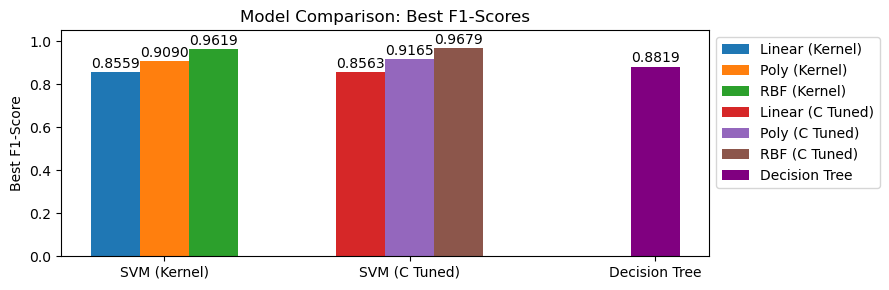

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Groups (models + hyperparameter)
groups = ['SVM (Kernel)', 'SVM (C Tuned)', 'Decision Tree']

# Kernels for SVM
kernels = ['Linear', 'Poly', 'RBF']

# F1-Scores
f1_scores = {
    'SVM (Kernel)': [0.8559, 0.9090, 0.9619],
    'SVM (C Tuned)': [0.8563, 0.9165, 0.9679],
    'Decision Tree': [0.8819]  # Only one value
}

# Plotting
x = np.arange(len(groups))
width = 0.2  # width of bars

fig, ax = plt.subplots(figsize=(9,3))

# Function to add labels on top of bars
def add_labels(bars, values):
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{val:.4f}', ha='center', va='bottom')

# SVM Kernel bars
bars1 = [
    ax.bar(x[0] - width, f1_scores['SVM (Kernel)'][0], width, label='Linear (Kernel)'),
    ax.bar(x[0], f1_scores['SVM (Kernel)'][1], width, label='Poly (Kernel)'),
    ax.bar(x[0] + width, f1_scores['SVM (Kernel)'][2], width, label='RBF (Kernel)')
]
# Add labels
for b, val in zip(bars1, f1_scores['SVM (Kernel)']):
    add_labels(b, [val])

# SVM C Tuned bars
bars2 = [
    ax.bar(x[1] - width, f1_scores['SVM (C Tuned)'][0], width, label='Linear (C Tuned)'),
    ax.bar(x[1], f1_scores['SVM (C Tuned)'][1], width, label='Poly (C Tuned)'),
    ax.bar(x[1] + width, f1_scores['SVM (C Tuned)'][2], width, label='RBF (C Tuned)')
]
# Add labels
for b, val in zip(bars2, f1_scores['SVM (C Tuned)']):
    add_labels(b, [val])

# Decision Tree bar
bar_dt = ax.bar(x[2], f1_scores['Decision Tree'][0], width, color='purple', label='Decision Tree')
add_labels(bar_dt, f1_scores['Decision Tree'])

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel('Best F1-Score')
ax.set_ylim(0, 1.05)
ax.set_title('Model Comparison: Best F1-Scores')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()
